# Training

In [1]:
#from tsne_torch import TorchTSNE as TSNE
import torch
import numpy as np
import os
import os.path as osp
import sklearn
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from EmotionPredictor.training import Trainer, SLP
from EmotionPredictor.data_tools import get_loaders
import EmotionPredictor.data_tools as dt

#from EmotionPredictor.evaluation import Report

%config InlineBackend.figure_format ='retina'

In [2]:
wikiart_embeddings_path = "../_data/wikiart_embeddings/"
clip_embedding_path = osp.join(wikiart_embeddings_path, "clip")
imagenet_embedding_path =  osp.join(wikiart_embeddings_path, "imagenet")
checkpoint_path = "../neural_checkpoints/"
results_path = "../results"

In [3]:
ARTEMIS_EMOTIONS = ['amusement',
 'awe',
 'contentment',
 'excitement',
 'anger',
 'disgust',
 'fear',
 'sadness',
 'something else']

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
reports = {}

In [6]:
save_figs = False 
save_networks = True
save_results = True


## <div class = "alert alert-success">Zero shot clip</div>

In [1133]:
emotions = ["A picutre making me feel " + emotion for emotion in ARTEMIS_EMOTIONS]
tokens = clip.tokenize(emotions).to(device)

In [1134]:
# We take RN50x16 as it is the best performing one 
model_zero_shot, _ = clip.load("RN50x16")

In [1135]:
image_features = dt.Pickle_data_loader("../data/wikiart_embeddings/clip_training/RN50x16/test/")

In [1136]:
imgs = torch.tensor([]).to(device)
from tqdm import tqdm
for x in tqdm(image_features) :
    imgs = torch.cat([imgs, x["image"]])


199it [00:06, 32.52it/s]


In [1137]:
labels = torch.tensor([])
with torch.no_grad():
    for x in image_features :
        labels = torch.cat([labels, x["label"]])
labels.shape

torch.Size([7933, 9])

In [1138]:
with torch.no_grad():
    text_features = model_zero_shot.encode_text(tokens)
    text_features = text_features.to(device)    

In [1139]:
imgs /= imgs.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * imgs.float() @ text_features.T.float()).softmax(dim=-1)


In [1037]:
metrics = ct.compute_metrics_for_threshold(similarity.detach().cpu().numpy(),
                                 labels.detach().cpu().numpy(),
                                 confusion_labels=ARTEMIS_EMOTIONS,
                                 agreement_threshold=0.501)
if save : 
    path = "../results/clip_training/zero_shot"
    if not osp.exists(path) : os.mkdir(path)
    ct.export_results(metrics, path)

In [1239]:
report = evaluation.Report(results, labels.numpy(), ARTEMIS_EMOTIONS, 0.5)

In [1338]:
reports["zero_shot"] = report 

# Training

## <div class = "alert alert-success">Binary classification</div>

For classifying the emotions as positive or negative we follow the documentation of artemis and put <b>something</b> else as a separate class.

In [1328]:
import torch.nn.functional as F
import copy


In [1329]:
# Positive affect : 
positive_emotions = ARTEMIS_EMOTIONS[:4]
print(f"List of postive emotions : {positive_emotions}")

negative_emotions = ARTEMIS_EMOTIONS[4:8]
print(f"List of negative emotions : {negative_emotions}")

something_else = ARTEMIS_EMOTIONS[-1]
print(f"Non positive or negative emotion : {something_else}")

POSITIVE_MASK = torch.tensor(np.isin(ARTEMIS_EMOTIONS, positive_emotions))
NEGATIVE_MASK = torch.tensor(np.isin(ARTEMIS_EMOTIONS, negative_emotions))
SOMETHING_ELSE_MASK = torch.tensor(np.isin(ARTEMIS_EMOTIONS, something_else))

def positive_negative_binaring():
    def batch_binaring(batch):
        pos_sum = batch["label"][:,POSITIVE_MASK].sum(1)
        neg_sum = batch["label"][:,NEGATIVE_MASK].sum(1)
        sth_else_sum = batch["label"][:,SOMETHING_ELSE_MASK].sum(1)
        #one_hot_emotion = F.one_hot(torch.tensor(list(zip(pos_sum,neg_sum, sth_else_sum))).argmax(1),3)
        batch["label"] = torch.hstack([pos_sum.unsqueeze(1),
                                       neg_sum.unsqueeze(1),
                                       sth_else_sum.unsqueeze(1)])
        return batch
    return batch_binaring

def float_my_batch(batch):
    batch["label"] = batch["label"].float()
    return batch



List of postive emotions : ['amusement', 'awe', 'contentment', 'excitement']
List of negative emotions : ['anger', 'disgust', 'fear', 'sadness']
Non positive or negative emotion : something else


In [1330]:
del Trainer
from training import Trainer
imp.reload(training)


<module 'training' from '/scratch/students/2021-fall-mt-rszymcza/code/training.py'>

In [1331]:
learning_rate = 10**-2
loaders = dt.get_loaders(path = "../data/wikiart_embeddings/clip_training/RN50x16/",
                     transformations=[positive_negative_binaring(), float_my_batch])

binary_classifier = Trainer(model=SLP(input_size=768,output_size=3),
                                        loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1,1,1]).to(device)),
                                        data_loaders= loaders,
                                        optimizer_fn = torch.optim.Adam,
                                         lr = learning_rate,
                                        device=device)

binary_classifier.class_labels = ["positive", "negative", "somthing_else"]

In [1332]:
binary_classifier.test_network()

Your model is running correctly. Rejoice ! :-)


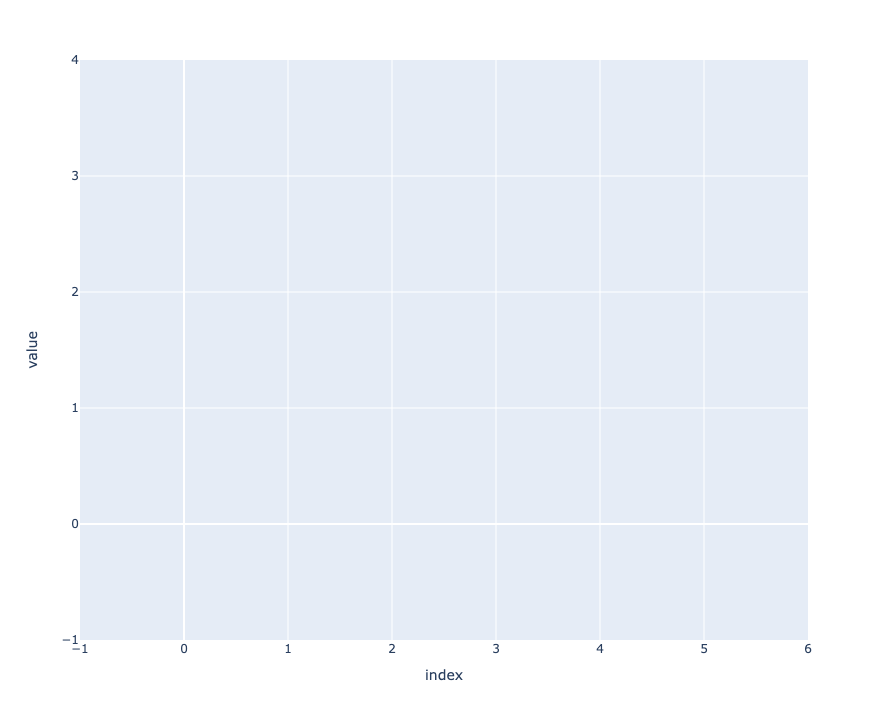

In [1339]:
lrs = [10**-2, 10**-3, 10**-4, 10**-5]
binary_classifier.train_eval(3, lrs)
clear_output()
px.line(binary_classifier.epoch_losses)

In [1335]:
ct.create_report(binary_classifier,["positive", "negative", "other"],
                 agreement_threshold=0.501,
                 normalize_confusion = False)

if save :
    path = "../results/clip_training/RN50x16/binary"
    if not osp.exists(path) : os.mkdir(path)
    export_results(binary_classifier.get_last_metrics(), path)

AttributeError: 'Trainer' object has no attribute 'reports'

In [665]:
if save :
    path = "../neural_checkpoints/slp_3_classes"
    torch.save(binary_classifier.model.state_dict(), path)



## <div class = "alert alert-success"> Train a layer for every clip architecture and imagenet </div>

In [1028]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [ ]:
def recreate_dir(path, new_path, ignore = None):
    ignore = ignore if ignore is not None else []
    for directory in os.listdir(path):
        if osp.isdir(osp.join(path, directory)):
            if directory is not None:
                if directory in ignore: 
                    continue
            os.mkdir(osp.join(new_path,directory))
            recreate_dir(osp.join(path,directory), osp.join(new_path,directory), ignore)
             
recreate_dir(wikiart_embeddings_path, "test", ignore = ["test", "rest", "val", "train"])

In [8]:
def train_on_dataset(path):
    """Fix the parameters for the training on the ArtEmis features"""
    loaders = get_loaders(path)
    input_shape = (loaders["train"].load_batch(0))["image"].shape[1]
    return Trainer(model = SLP(input_size = input_shape, output_size=9).to(device),
                        loss_fn = nn.BCEWithLogitsLoss(),
                        optimizer_fn = torch.optim.Adam,
                        lr = 10**-2,
                        data_loaders = loaders,
                        device = device)

In [9]:
data_path = "../_data"
wikiart_embeddings_path = osp.join(data_path, "wikiart_embeddings")
clip_embedding_path = osp.join(wikiart_embeddings_path, "clip")
imagenet_embedding_path = osp.join(wikiart_embeddings_path, "imagenet")
checkpoint_path = "../neural_checkpoints/"

models = {}
for name in ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B32', 'ViT-B16']:
    path = osp.join(clip_embedding_path, name)
    if not osp.exists(path):
        print(f"embeddings for {name} not found, please extract them before proceeding")
    name = "C-" + name #clip indicator
    models[name] = train_on_dataset(path)
    if name in os.listdir(checkpoint_path):
        models[name].model.load_state_dict(torch.load(osp.join(checkpoint_path, name)))
    
for name in ["alexnet", "resnet50"]:
    path = osp.join(imagenet_embedding_path, name)
    if not osp.exists(path):
        print(f"embeddings for {name} not found, please extract them before proceeding")
    name = "I-" + name #imagenet indicator
    models[name] = train_on_dataset(path)
    if name in os.listdir(checkpoint_path):
        models[name].model.load_state_dict(torch.load(osp.join(checkpoint_path,name)))
                                           


In [ ]:
for model in models.values() :
    model.test_network()


In [1390]:
lrs = 10.**np.arange(-2, -6, -1)
for model in models.values() : 
    model.train_eval(4, lrs = lrs)
    clear_output()

In [ ]:
for key, slp in slps.items() :
    ct.create_report(slp, ARTEMIS_EMOTIONS, False, show_fig=True, agreement_threshold=0.501)
    export_results(slp.get_last_metrics(), osp.join("../results/clip_training/",key))

In [1393]:
from ipywidgets import interact

@interact(options = ["train", "validation"])
def losses(train_val = "train"):
    if train_val == "train":
        plot_data = [pd.Series(model.epoch_losses, name=name) for name, model in models.items()]
    else :
        plot_data = [pd.Series(model.validation_losses, name=name) for name, model in models.items()]
    x = pd.DataFrame(plot_data)
    fig = px.line(x.T)
    return fig
    

interactive(children=(Text(value='train', description='train_val'), Output()), _dom_classes=('widget-interact'…

In [1431]:
if save_networks :
    for name, model in models.items() :
        PATH = osp.join(checkpoint_path, name)
        model.save_model(PATH)

In [ ]:
if save_results :
    test_results_path = osp.join(results_path, "test_results")
    if not osp.exists(test_results_path) : os.mkdir(test_results_path)
    for name, model in models.items() :
        model.create_report(ARTEMIS_EMOTIONS, show_fig = False)
        path = osp.join(test_results_path,name)
        if not osp.exists(path): os.mkdir(path)
        model.save_labels_results(path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Train on max pooled data

In [1293]:
imp.reload(ct)
model_max = ct.copy_model_data(test)
for key, loader in model_max.data_loaders.items():
    loader.add_transformation(ct.max_pool())
    loader.add_transformation(float_my_batch)
model_max.lr = 10**-2

Optimizer successfully updated. :)
Optimizer successfully updated. :)


In [1294]:
model_max.test_network(10)

Your model is running correctly. Rejoice ! :-)


In [ ]:
model_max.lr = 10**-4
model_max.train_n_epochs(13)

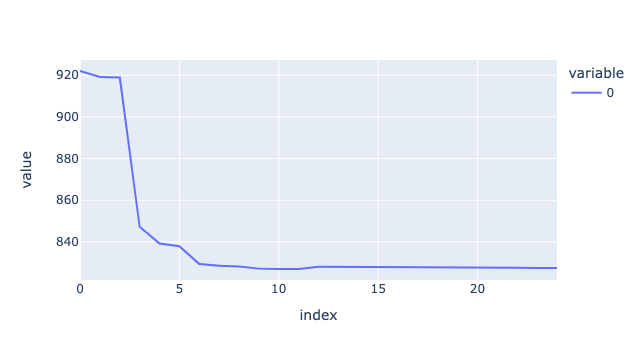

In [1303]:
px.line(model_max.epoch_losses)

showing results with agreements of 50.0% at epoch n°25



,amusement,awe,contentment,excitement,anger,disgust,fear,sadness,something else
precision,0.39,0.42,0.55,0.27,0.0,0.36,0.47,0.40,0.34
recall,0.43,0.40,0.75,0.09,0.0,0.11,0.38,0.29,0.15
f1_score,0.41,0.41,0.63,0.14,0.0,0.16,0.42,0.33,0.21
support,1141.00,1536.00,2776.00,403.00,40.0,227.00,640.00,635.00,535.00



the recall is 0.47

the f1_score is 0.47

the accuracy is 0.47


<Figure size 1296x1296 with 0 Axes>

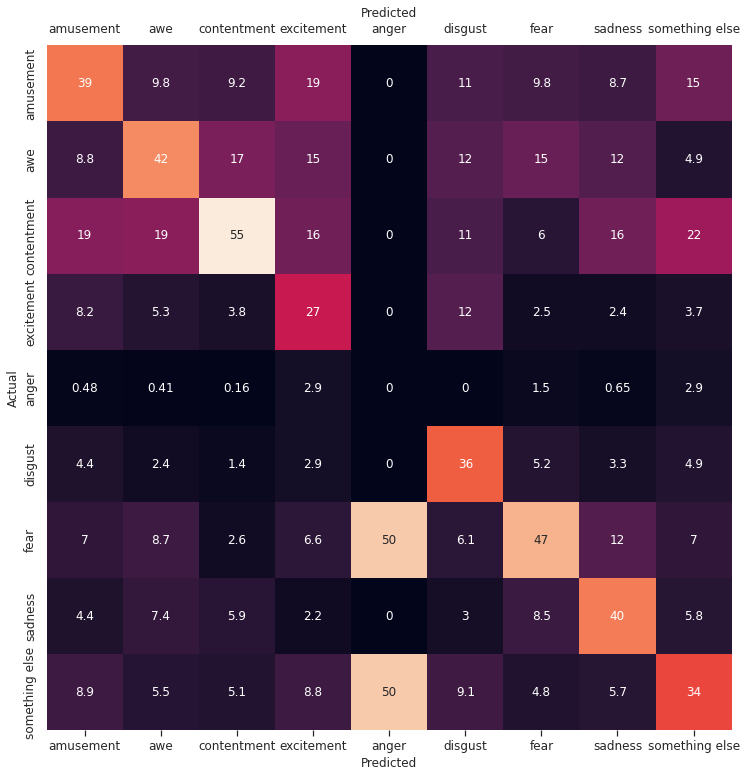

In [1324]:
imp.reload(ct)
ct.create_report(model_max, confusion_labels=ARTEMIS_EMOTIONS, normalize_confusion_mat=True)

## <div class = "alert alert-warning"> Model trained on 9 emotions as binary classifier </div>



In [1011]:
result_to_binarise = slps["RN50x16"].get_last_results()["results"]


In [894]:
bineriser = positive_negative_binaring()


In [925]:
result_binarised = bineriser({"label": torch.tensor(result_to_binarise).softmax(1)})["label"].numpy()
labels_binariser = r["label"].numpy()

In [943]:
ct.compute_metrics_for_threshold(result_binarised,
                                 labels_binariser,
                                 agreement_threshold=0.501,
                                 confusion_labels = ["positive", "negative", "other"] )
#ct.plot_confusion_matrix(ct.create_confusion_matrix(labels_binariser, 
 #                                                   result_binarised))

{'agreement_threshold': 0.501,
 'labels_thresholded': array([ True,  True,  True, ...,  True, False,  True]),
 'confusion_matrix':           positive  negative  other
 positive      4888       283     21
 negative       649       754      6
 other          113        21     19,
 'precision_recall_fscore_support': (array([0.86513274, 0.71266541, 0.41304348]),
  array([0.94144838, 0.5351313 , 0.12418301]),
  array([0.90167866, 0.61126875, 0.19095477]),
  array([5192, 1409,  153])),
 'recall': 0.5335875624852555,
 'f1_score': 0.5679673928034152,
 'accuracy': 0.8381699733491265}

## Raw images

In [392]:
img_loaders = dt.get_loaders("../data/wikiart_preprocessed_for_clip_vit_32/")

In [ ]:
name = "img_size_224"
path = osp.join(data_path, "preprocessed", name)
if not osp.exists(path):
    print(f"embeddings for {name} not found, please extract them before proceeding")
models["Raw-img"] = train_on_dataset(path)

In [403]:
clip_img = ct.Model_data(model = SLP(input_size=150528, output_size=9).to(device),
                         loss_fn = nn.BCEWithLogitsLoss(),
                         optimizer_fn = torch.optim.Adam,
                         lr=10**-3,
                         data_loaders=img_loaders,
                         device=device)

Optimizer successfully updated. :)


In [404]:
clip_img.lr = 10**-4
clip_img.test_network(100)

Your model is running correctly. Rejoice ! :-)


In [405]:
ct.train_eval?

Signature: ct.train_eval(model_data, epochs_per_lr, lrs, run_check=False)
Docstring: <no docstring>
File:      /scratch/students/2021-fall-mt-rszymcza/code/custom.py
Type:      function


In [406]:
ct.train_eval(clip_img, 5, [10**-3,10**-4,10**-5])

Optimizer successfully updated. :)
The model was trained for 0 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [18357.591923594475]
val loss is 586.0711286067963
Optimizer successfully updated. :)
The model was trained for 1 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [15895.574835777283]
val loss is 577.9117608070374
Optimizer successfully updated. :)
The model was trained for 2 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [14941.595450878143]
val loss is 616.8132903575897
stoped at learning rate 0.001
Optimizer successfully updated. :)
The model was trained for 3 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [4482.337809622288]
val loss is 149.18121194839478
Optimizer successfully updated. :)
The model was trained for 4 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [3461.2058340907097]
val loss is 133.92303025722504
Optimizer successfully updated. :)
The model was trained for 5 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [3069.456661581993]
val loss is 134.10118234157562
stoped at learning rate 0.0001
Optimizer successfully updated. :)
The model was trained for 6 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [2446.651347398758]
val loss is 97.84504157304764
Optimizer successfully updated. :)
The model was trained for 7 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [2370.632311373949]
val loss is 96.57157212495804
Optimizer successfully updated. :)
The model was trained for 8 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [2326.244360923767]
val loss is 95.6239395737648
Optimizer successfully updated. :)
The model was trained for 9 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [2288.2318639457226]
val loss is 94.79796290397644
Optimizer successfully updated. :)
The model was trained for 10 epochs, training for 1 more!


0it [00:00, ?it/s]

Success, training losses are [2253.8113752007484]
val loss is 94.04104781150818


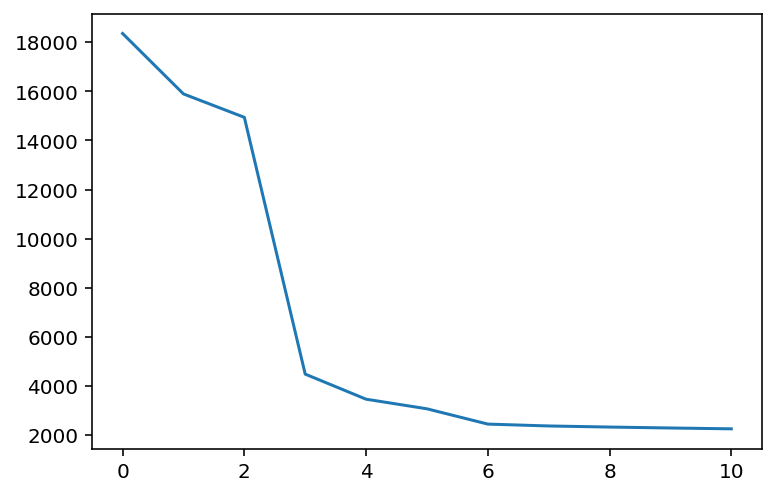

In [407]:
plt.plot(clip_img.epoch_losses)

In [124]:
torch.cuda.empty_cache()

showing results with agreements of 51.0% at epoch n°11



,amusement,awe,contentment,excitement,anger,disgust,fear,sadness,something else
precision,0.09,0.17,0.56,0.04,0.0,0.02,0.13,0.11,0.03
recall,0.12,0.19,0.43,0.04,0.0,0.05,0.12,0.09,0.05
f1_score,0.10,0.18,0.49,0.04,0.0,0.03,0.13,0.10,0.04
support,230.00,387.00,1497.00,123.00,5.0,39.00,274.00,315.00,153.00



the recall is 0.12

the f1_score is 0.12

the accuracy is 0.27


<Figure size 432x288 with 0 Axes>

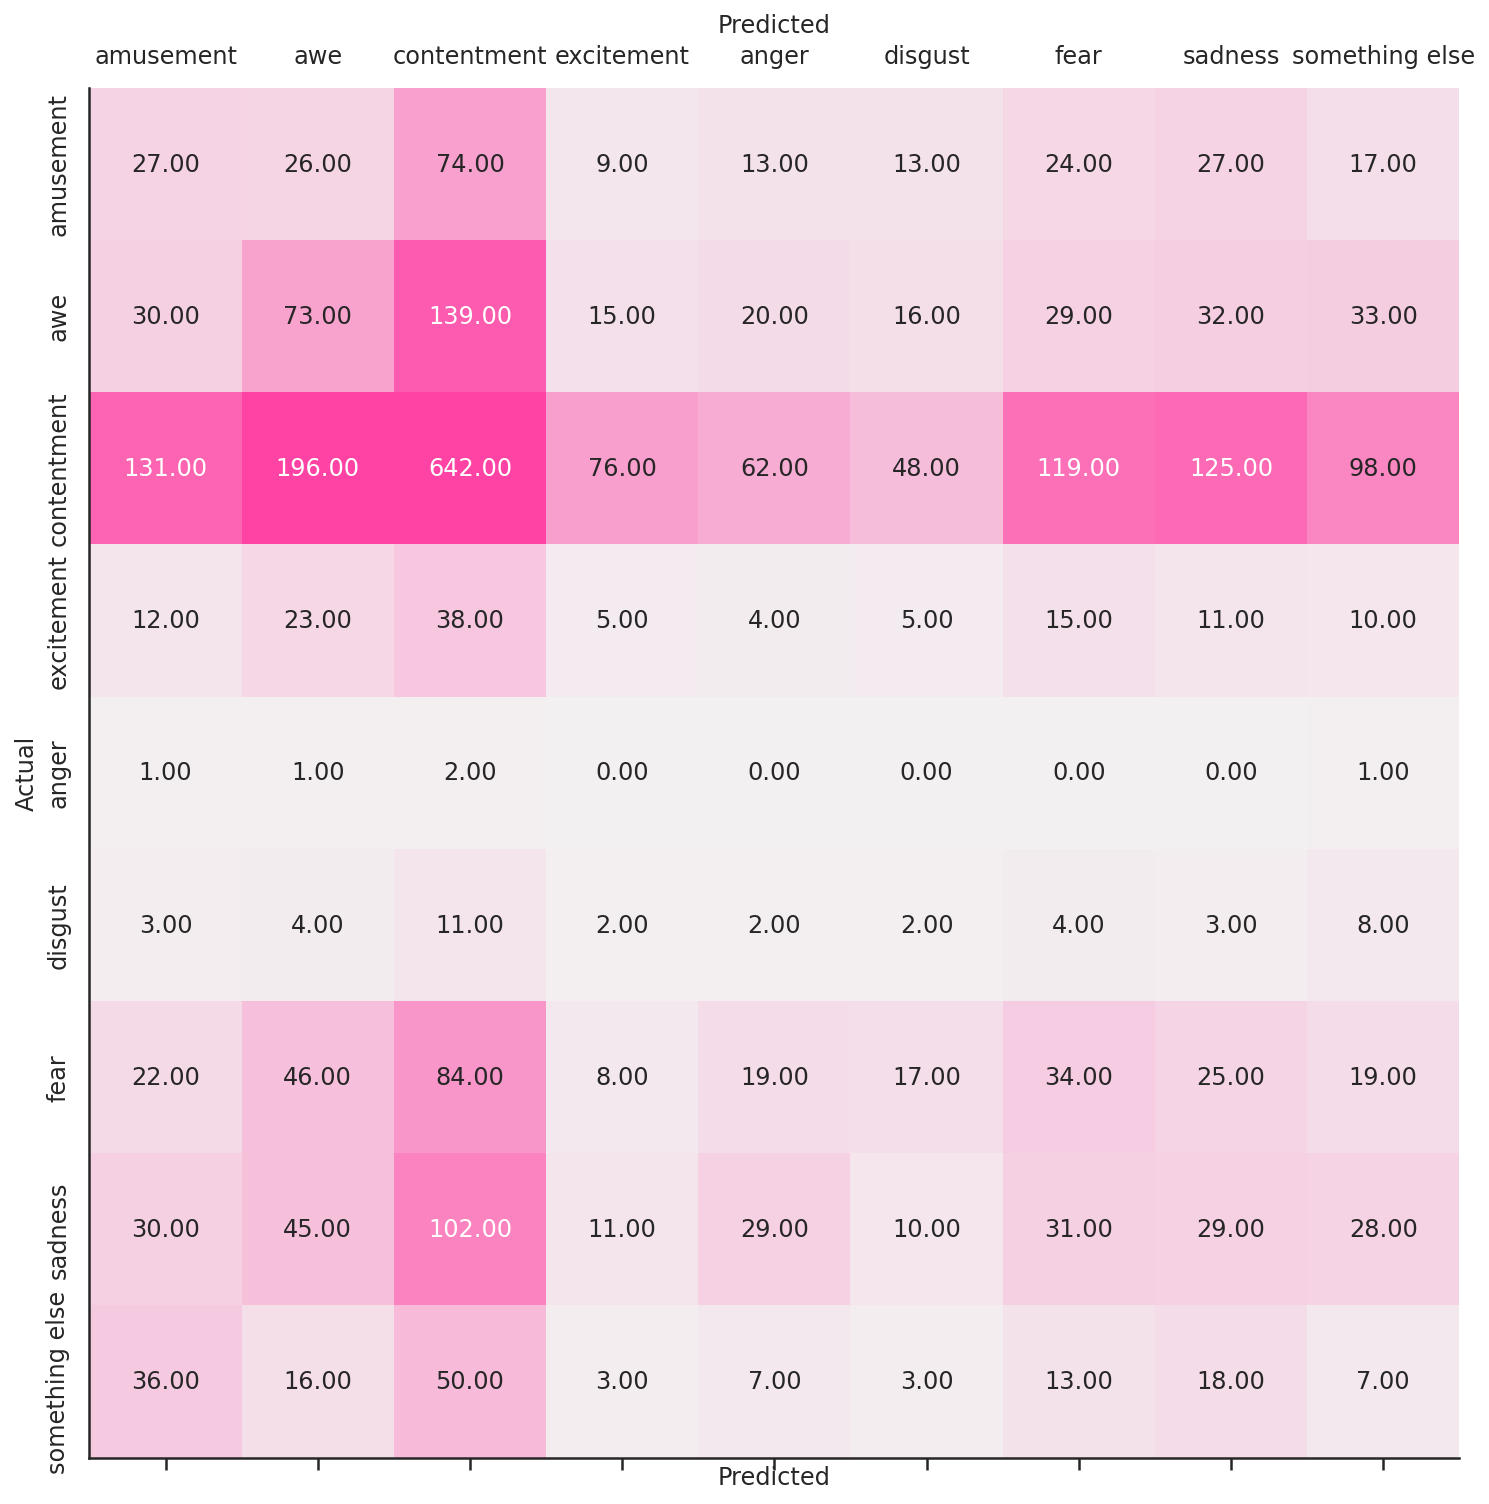

In [938]:
sns.plotting_context(context = "notebook")
ct.create_report(clip_img, ARTEMIS_EMOTIONS, False, agreement_threshold=0.51)

<Figure size 432x288 with 0 Axes>

<Figure size 907.2x907.2 with 0 Axes>

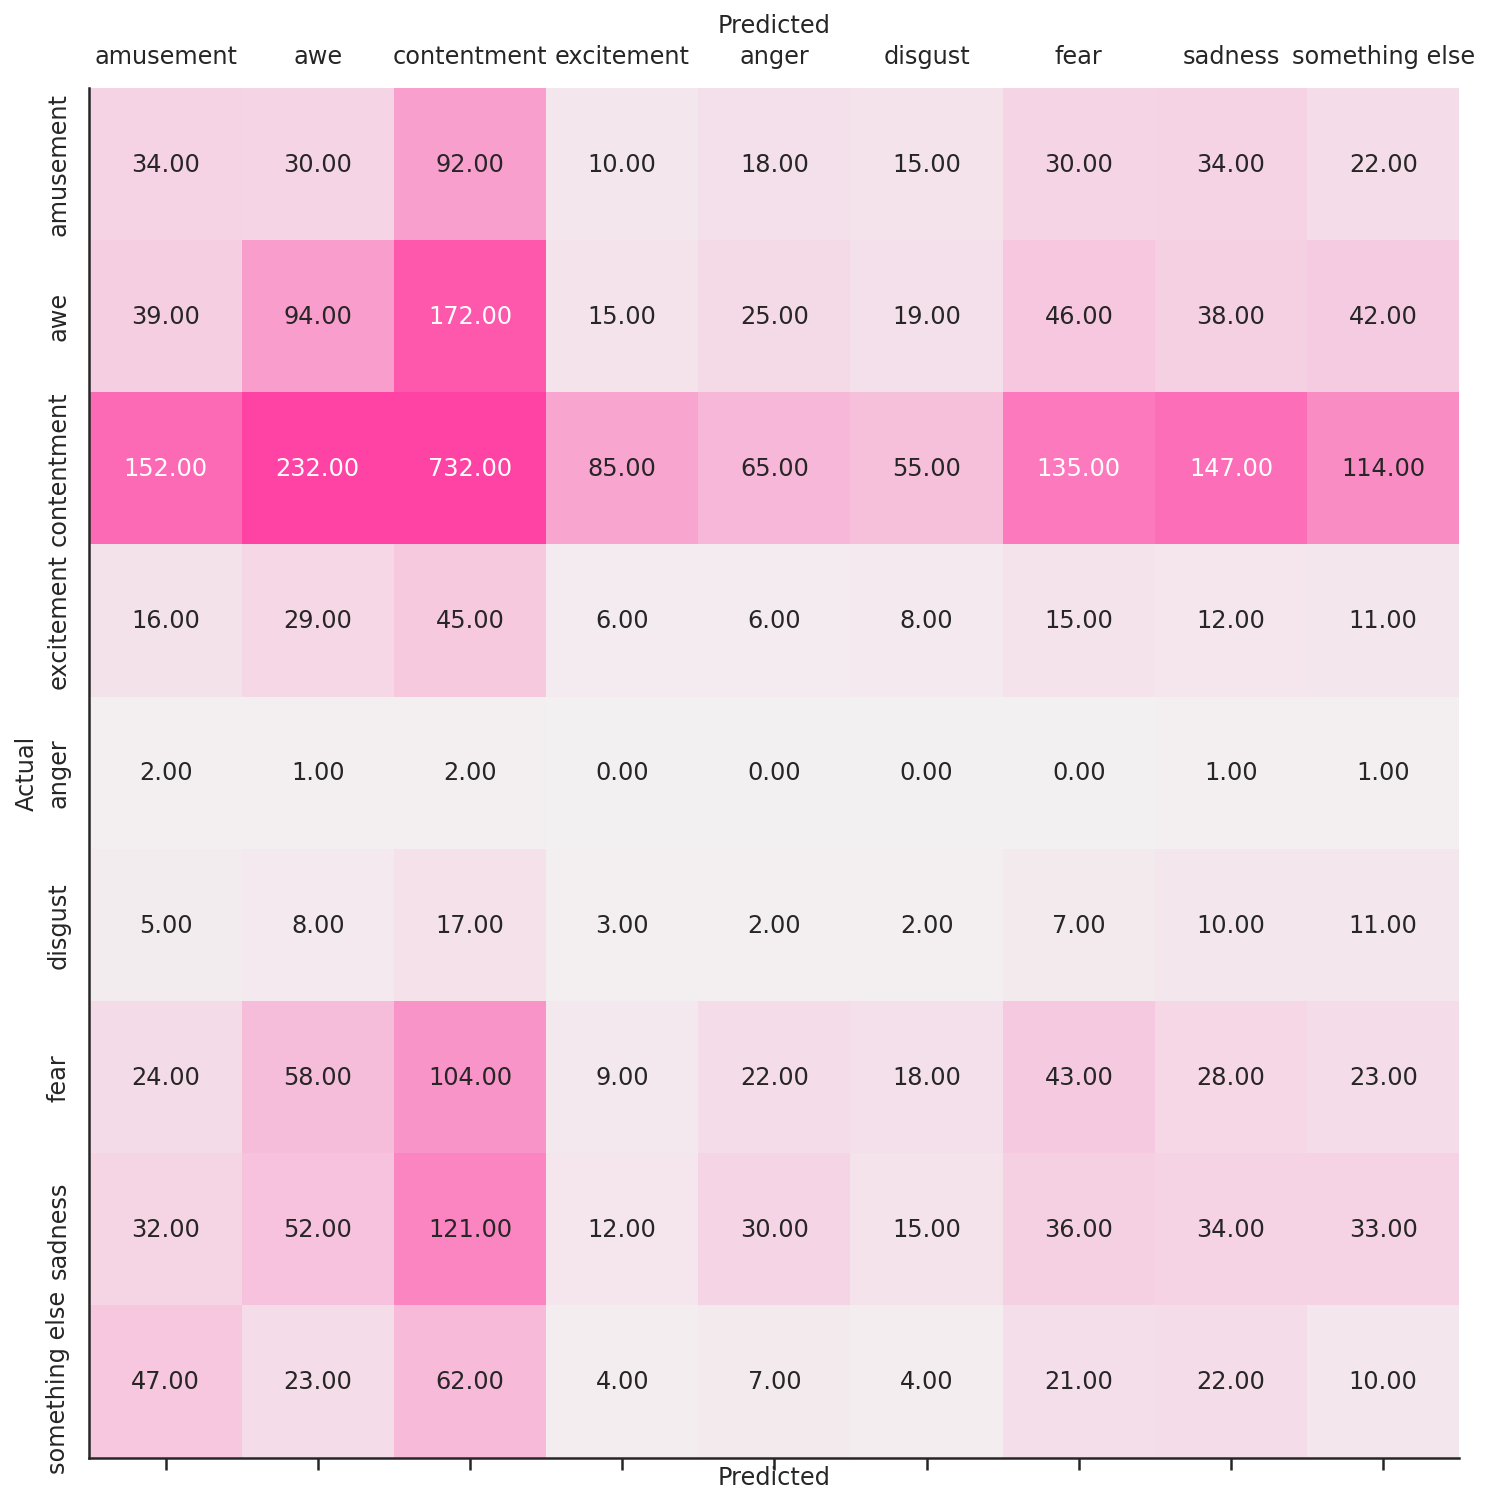

In [934]:
export_results(clip_img.get_last_metrics(),"../results/raw_image/")

##  <div class = "alert alert-warning"> Sentiment analysis </div>
This is a quick test on the emotion classifier to be used as a predictor of sentiments in tweets. The results are not concluent.

In [1047]:
binary_classifier

In [1038]:
clip_RN50x16, _ = clip.load("RN50x16")

In [1039]:
clip_RN50x16 = clip_RN50x16.eval()
binary_classifier.model = binary_classifier.model.eval()

Optimizer successfully updated. :)


In [1048]:
nlp_sentiment = pd.read_csv("../data/text/sentiment_test.csv",encoding = 'ISO-8859-1')
nlp_sentiment.head(2)

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0


In [1042]:
sentiments = dict(zip(range(3),["positive", "negative", "neutral"] ))
sentiments

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [1043]:
with torch.no_grad():
    nlp_sentiment = nlp_sentiment[~nlp_sentiment.text.isna()]
    tokens = nlp_sentiment.text.map(lambda y : clip.tokenize(y).to(device))
    nlp_sentiment["preds"] = tokens.map(clip_RN50x16.encode_text).map(binary_classifier.model).map(lambda y : sentiments[y.argmax().tolist()])

/tmp/ipykernel_3236/496501949.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1044]:
nlp_sentiment_preds = nlp_sentiment[["text","sentiment","preds"]]
nlp_sentiment_preds                                                                    

,text,sentiment,preds
0,Last session of the day http://twitpic.com/67ezh,neutral,negative
1,Shanghai is also really exciting (precisely -...,positive,negative
2,"Recession hit Veronique Branquinho, she has to...",negative,negative
3,happy bday!,positive,positive
4,http://twitpic.com/4w75p - I like it!!,positive,positive
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative,positive
3530,All alone in this old house again. Thanks for...,positive,positive
3531,I know what you mean. My little dog is sinkin...,negative,positive
3532,_sutra what is your next youtube video gonna b...,positive,positive


In [1027]:
a = sklearn.metrics.precision_recall_fscore_support(y_true=nlp_sentiment_preds.sentiment, y_pred=nlp_sentiment_preds.preds )
#sklearn.metrics.precision_recall_fscore_support(labels_argmax, results_argmax)
conf = pd.DataFrame(a, columns = ["negative", "positive", "neutral"])
conf.index = ["precision", "recall", "f1_score", "support"]
conf

,negative,positive,neutral
precision,0.532407,0.459016,0.337060
recall,0.229770,0.019580,0.929284
f1_score,0.321005,0.037559,0.494691
support,1001.000000,1430.000000,1103.000000


The binary classifier has limited performance for sentiment analysis

# Linear regression

In [948]:
def get_features(loader):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for data in tqdm(loader):
            all_features.append(data["image"].cpu())
            all_labels.append(data["label"].cpu())
    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()


# Calculate the image features
train_features, train_labels = get_features(dt.Pickle_data_loader("../data/wikiart_embeddings/clip_training/RN50x16/train/"))
test_features, test_labels = get_features(dt.Pickle_data_loader("../data/wikiart_embeddings/clip_training/RN50x16/test/"))





3372it [00:47, 70.89it/s] 
199it [00:06, 31.17it/s]


NameError: name 'LogisticRegression' is not defined

In [957]:
from sklearn.linear_model import LinearRegression
# Perform logistic regression
classifier = LinearRegression()
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
ct.compute_metrics_for_threshold(predictions, test_labels, agreement_threshold = 0.501, confusion_labels=ARTEMIS_EMOTIONS)
#accuracy = np.mean((test_labels.argmax(1) == predictions).astype(np.float)) * 100.
#print(f"Accuracy = {accuracy:.3f}")

/home/robin/miniconda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'agreement_threshold': 0.501,
 'labels_thresholded': array([False,  True,  True, ..., False, False, False]),
 'confusion_matrix':                 amusement  awe  contentment  excitement  anger  disgust  fear  \
 amusement             126   12           60           3      0        1     8   
 awe                     7  172          169           2      0        0    23   
 contentment            18   47         1370           2      0        0    12   
 excitement             12   10           59          27      0        1    12   
 anger                   1    0            0           0      0        0     3   
 disgust                10    2            9           0      0        4     5   
 fear                    9   25           39           1      0        0   167   
 sadness                 8   15           92           2      0        0    31   
 something else         16    8           45           4      0        1     8   
 
                 sadness  something else  
 amus

showing results with agreements of 50.1% at epoch n°10



,amusement,awe,contentment,excitement,anger,disgust,fear,sadness,something else
precision,0.60,0.61,0.76,0.52,0.0,0.31,0.63,0.66,0.54
recall,0.57,0.47,0.90,0.28,0.0,0.23,0.63,0.55,0.41
f1_score,0.58,0.53,0.83,0.37,0.0,0.26,0.63,0.60,0.46
support,230.00,387.00,1497.00,123.00,5.0,39.00,274.00,315.00,153.00



the recall is 0.45

the f1_score is 0.47

the accuracy is 0.7


<Figure size 432x288 with 0 Axes>

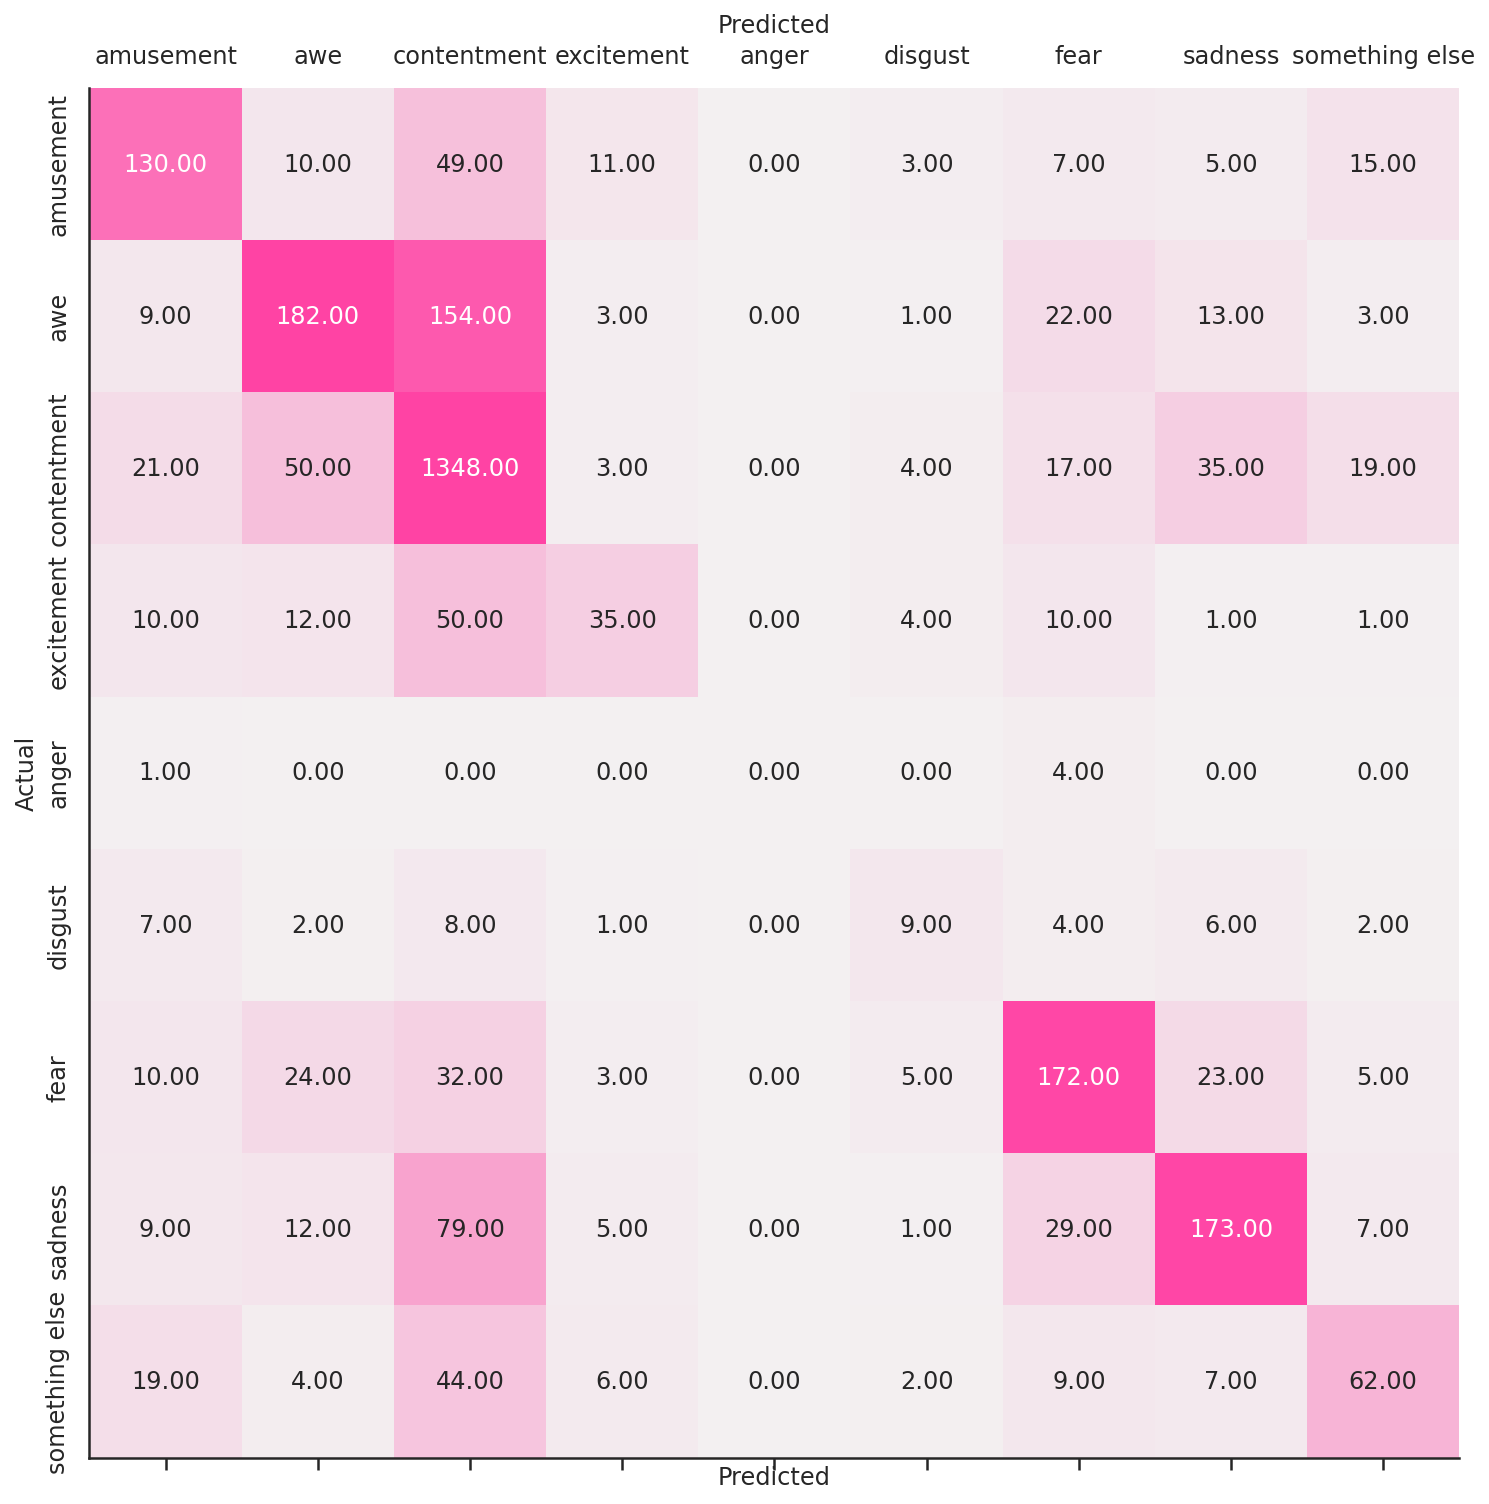

In [960]:
ct.create_report(slps["RN50x16"], ARTEMIS_EMOTIONS,agreement_threshold=0.501 )

In [1075]:
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
sklearn.metrics.f1_score()

In [ ]:
ct.get_empty_reports

In [1132]:
imp.reload(ct)
#@interact(widgets.Combobox(options = list(slps.keys())))
def plot(a, b, normalize):
    return ct.create_report(slps[a], ARTEMIS_EMOTIONS, agreement_threshold = b, normalize_confusion = normalize)
    #ct.show_results(slps[a], slps[a].epochs_trained_on, threshold = 0.501)
    
interact(plot,  normalize = True, a = list(slps.keys()), b = (0.5, 1, 0.05));

interactive(children=(Dropdown(description='a', options=('RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B32', 'ViT…

showing results with agreements of 80.0% at epoch n°12



ValueError: 9 columns passed, passed data had 8 columns

<Figure size 432x288 with 0 Axes>

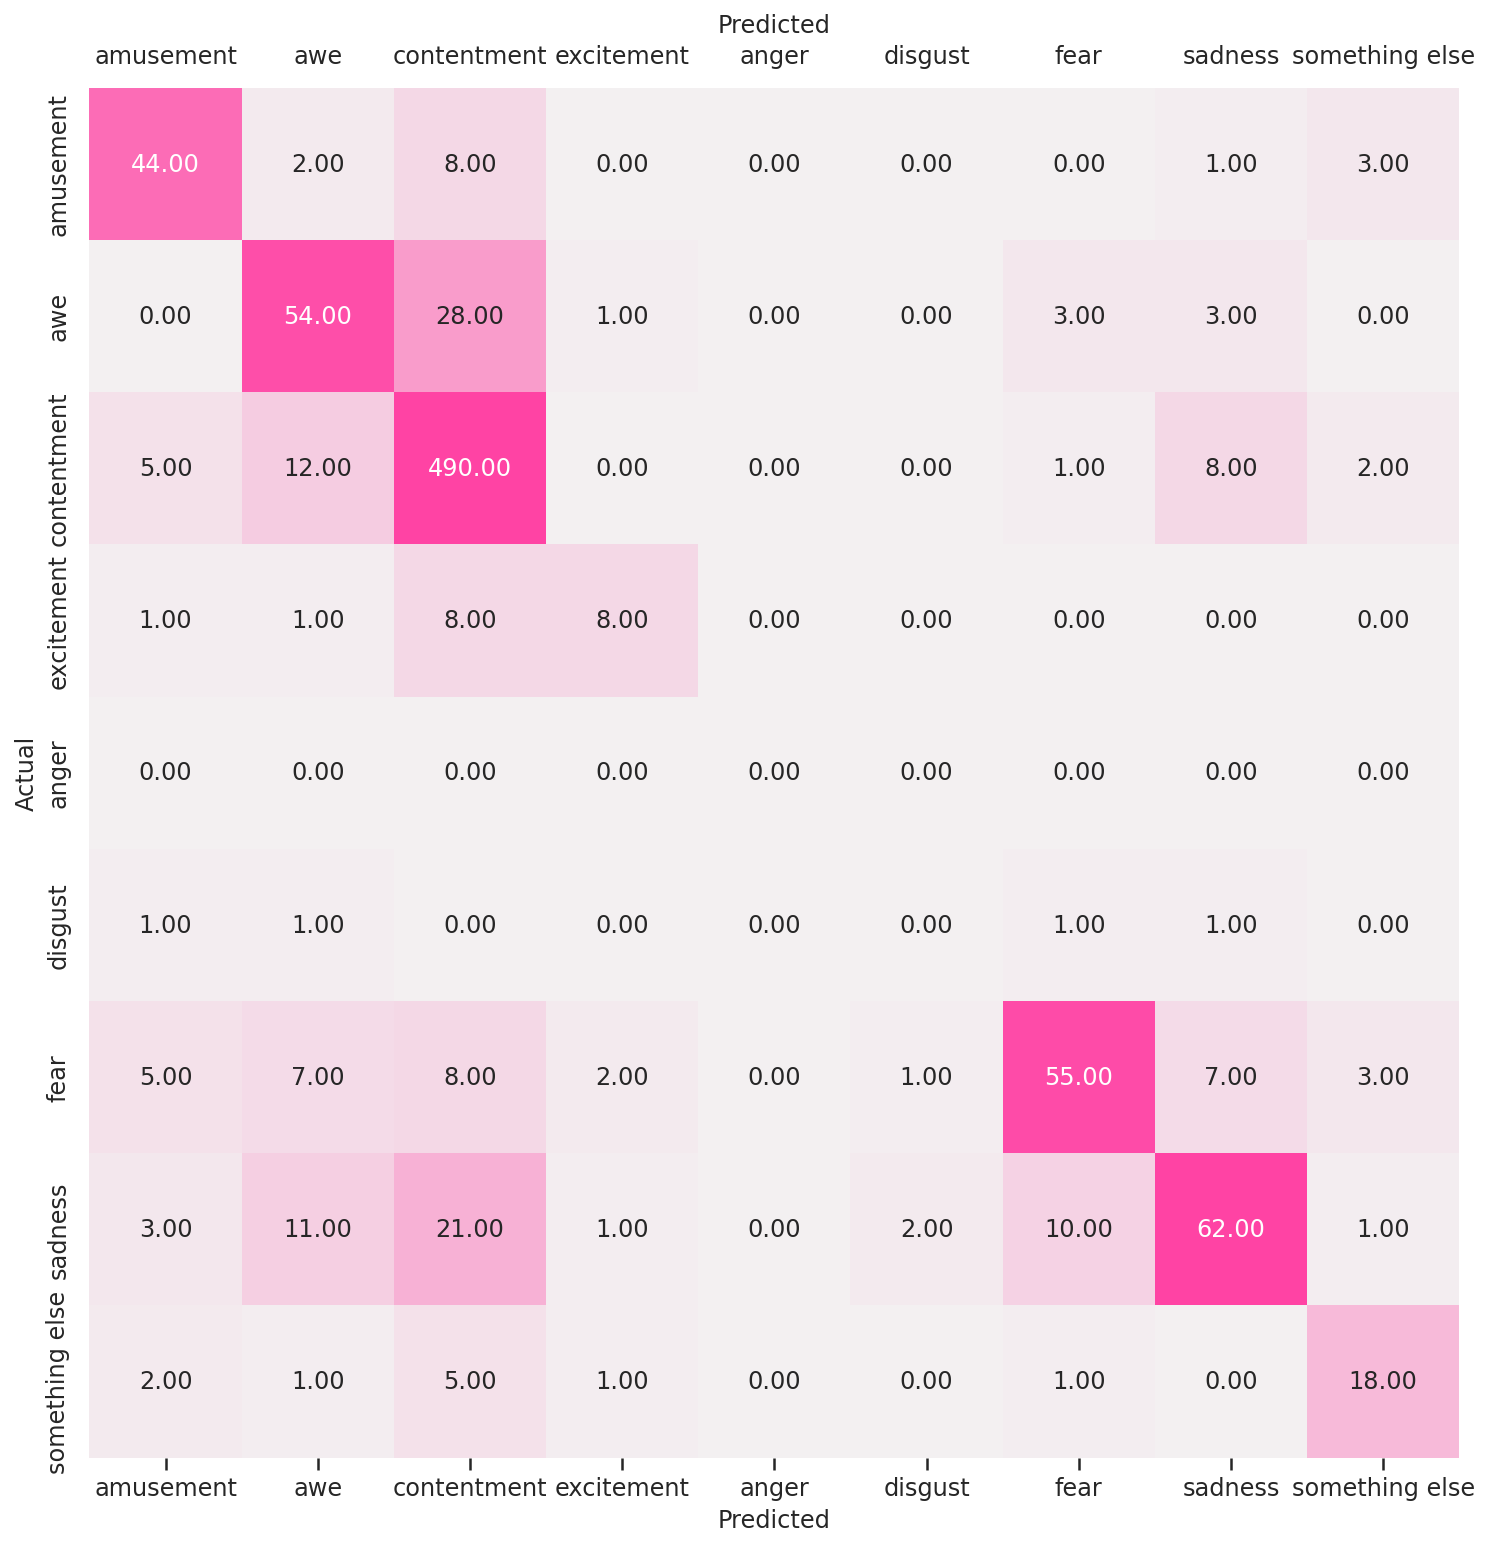

In [1110]:
ct.create_report(slps["RN50"], ARTEMIS_EMOTIONS, agreement_threshold=0.8)


In [1111]:
slps["RN50"].get_last_metrics()

{'agreement_threshold': 0.1,
 'labels_thresholded': array([ True,  True,  True, ...,  True,  True,  True]),
 'confusion_matrix':                 amusement  awe  contentment  excitement  anger  disgust  fear  \
 amusement             321   93          437          37      0       14    80   
 awe                    47  428          773          28      0       11   111   
 contentment           101  145         2216          18      0        5    51   
 excitement             50   57          163          60      0        3    23   
 anger                   3    4            7           4      0        0     7   
 disgust                26   18           70           7      0       17    41   
 fear                   40   77          133          12      0        2   271   
 sadness                15   70          251           6      0        3    68   
 something else         54   39          217          13      0        4    43   
 
                 sadness  something else  
 amusem

In [1086]:
a = widgets.RadioButtons()
a

RadioButtons(options=(), value=None)

In [1077]:
slps

{'RN50': <custom.Model_data at 0x7f8785052220>,
 'RN101': <custom.Model_data at 0x7f8785d70730>,
 'RN50x4': <custom.Model_data at 0x7f8785d70280>,
 'RN50x16': <custom.Model_data at 0x7f8785d70f70>,
 'ViT-B32': <custom.Model_data at 0x7f8785d03a60>,
 'ViT-B16': <custom.Model_data at 0x7f8785b855b0>}

In [1130]:
sklearn.metrics.precision_recall_fscore_support([3,3], [2,3], labels = range(4), zero_division=0)

(array([0., 0., 0., 1.]),
 array([0. , 0. , 0. , 0.5]),
 array([0.        , 0.        , 0.        , 0.66666667]),
 array([0, 0, 0, 2]))